# Part 1 - Introduction to Dense and CNN for secondary structure prediction

**About the project:**
* Here, we're trying to predict the secondary structure of a protein.
* We are categorizing each amino acid in a protein into one of three structural classes:
  * H (Alpha-Helix)
  * E (Beta-Strand)
  * C (Coil)
* We're using a Position-Specific Scoring Matrix (PSSM), that tells us how much a specific position in a protein has changed over in course of evolution.
* By looking at a window of 15 amino acids, the CNN can "see" several turns of a helix or a Beta-strand to make an informed decision based on the neighbours.

**Goal:**

* Buld a model that undestands context:
  * Dense ANN: Treats the 15-residue window as a flat list of numbers. It does not understand the relashionship between the neighbours => problem
  * CNN ResNet: Uses it's filters to scan the sequence and allows to
* As you stack layers, the gradient (the signal to learn) can vanish. The "shortcut" allows the gradient to flow through the network more easily, allowing you to train much deeper models.

##Example 1 : Secondary structure prediction

First, import some modules necessary for data analysis and transformation:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import requests
from tqdm.auto import tqdm

Mount google drive:

In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd  /content/drive/MyDrive
%mkdir M2BI_DRIVE
%cd  /content/drive/MyDrive/M2BI_DRIVE
%pwd

Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘M2BI_DRIVE’: File exists
/content/drive/MyDrive/M2BI_DRIVE


'/content/drive/MyDrive/M2BI_DRIVE'

In [3]:
def download_data():
  x_pssm500_DatasetTrainUrl    ='https://www.dsimb.inserm.fr/~gelly/data/x_pssm500.csv';
  x_aaindex500_DatasetValidUrl ='https://www.dsimb.inserm.fr/~gelly/data/x_aaindex500.csv';
  y_bfact_DatasetTrainUrl      ='https://www.dsimb.inserm.fr/~gelly/data/y_bfact500.csv';
  y_class_DatasetValidUrl      ='https://www.dsimb.inserm.fr/~gelly/data/y_class500.csv';
  datasetFolderPath = "dataset/"

  trainpssmFilePath     = os.path.join(datasetFolderPath, 'x_pssm500.csv')
  trainaaindexFilePath  = os.path.join(datasetFolderPath, 'x_aaindex500.csv')
  yclassFilePath        = os.path.join(datasetFolderPath, 'y_class500.csv')
  ybfactFilePath        = os.path.join(datasetFolderPath, 'y_bfact500.csv')


  if not os.path.exists(datasetFolderPath):
    os.makedirs(datasetFolderPath)

  def download_file(url, filename):
    response = requests.get(url, stream=True)
    with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                       total=int(response.headers.get('content-length', 0)),
                       desc=filename) as fout:
                       for chunk in response.iter_content(chunk_size=4096):
                         fout.write(chunk)

  if not os.path.exists(trainpssmFilePath):
    download_file(x_pssm500_DatasetTrainUrl, trainpssmFilePath)

  if not os.path.exists(trainaaindexFilePath):
    download_file(x_aaindex500_DatasetValidUrl, trainaaindexFilePath)

  if not os.path.exists(yclassFilePath):
    download_file(y_class_DatasetValidUrl, yclassFilePath)

  if not os.path.exists(ybfactFilePath):
    download_file(y_bfact_DatasetTrainUrl, ybfactFilePath)



In [4]:
download_data()

Read the data to variables (it will take some time for x since we have a lot of data):

In [5]:
X = np.loadtxt('dataset/x_pssm500.csv')

In [6]:
print(f'{X[0:10]}')
print(f'{X.shape}')

[[0.     0.     0.     ... 0.0159 0.188  0.    ]
 [0.     0.     0.     ... 0.0196 0.1862 0.    ]
 [0.     0.     0.     ... 0.0445 0.1348 0.    ]
 ...
 [0.05   0.0054 0.0501 ... 0.0885 0.0642 0.    ]
 [0.0536 0.0059 0.0523 ... 0.0172 0.096  0.    ]
 [0.0525 0.0058 0.0536 ... 0.0179 0.0772 0.    ]]
(99083, 330)


In [7]:
Y = np.loadtxt('dataset/y_class500.csv')

In [8]:
YB =  np.loadtxt('dataset/y_bfact500.csv')

In [9]:
Y_class =  np.loadtxt('dataset/y_class500.csv')

In [10]:
# cmap = plt.cm.get_cmap('PiYG', 7)

# Data analysis

How many examples do we have in our dataset?

In [11]:
print(f'X:\n {X}\nY:\n{Y}')
print(f'Shape of data X:{X.shape}\n')
print(f'Shape of data Y:{Y.shape}\n')

X:
 [[0.     0.     0.     ... 0.0159 0.188  0.    ]
 [0.     0.     0.     ... 0.0196 0.1862 0.    ]
 [0.     0.     0.     ... 0.0445 0.1348 0.    ]
 ...
 [0.052  0.0055 0.0503 ... 0.     0.     1.    ]
 [0.0509 0.0055 0.0552 ... 0.     0.     1.    ]
 [0.0506 0.0058 0.0503 ... 0.     0.     1.    ]]
Y:
[6. 3. 3. ... 3. 6. 6.]
Shape of data X:(99083, 330)

Shape of data Y:(99083,)



We will simplify our data for the first tests using only three types of SS. Once everything works, you can get back to the initial data.

In [12]:
Y3cl = np.zeros(len(Y))
Y3cl[((Y==0) | (Y==1) | (Y==2))] = 0 # helix H
Y3cl[((Y==3) | (Y==4))] = 1          # strand E
Y3cl[((Y==5) | (Y==6))] = 2          # coil C

In [13]:
# Frequency
print(f'Number of Helices: {sum(Y3cl==0)}\n')
print(f'Number of Strands: {sum(Y3cl==1)}\n')
print(f'Number of Coils: {sum(Y3cl==2)}\n')

Number of Helices: 40657

Number of Strands: 23022

Number of Coils: 35404



What is our class distribution?

<BarContainer object of 3 artists>

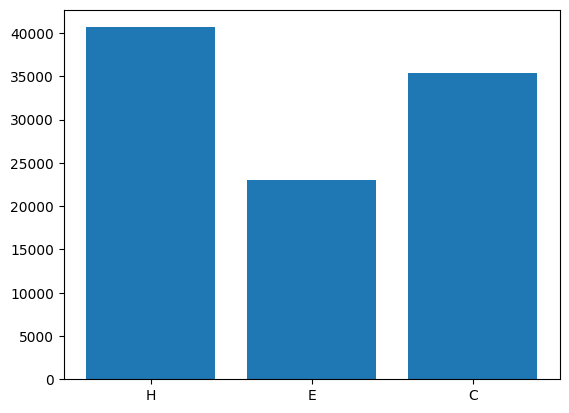

In [14]:
unique, counts = np.unique(Y3cl, return_counts=True)
plt.bar(["H", "E", "C"], counts)

# Prediction model

## Preparation

We import some modules for deep learning model construction.

In [15]:
!pip install scikeras

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D, Flatten
from scikeras.wrappers import KerasClassifier
#from keras.wrappers.scikit_learn import KerasClassifier
# Utily function from keras
#from keras.utils import np_utils
# Plot model
#from keras.utils import plot_model
# Optimizers
from tensorflow.keras import optimizers

# Useful Sklearn library
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import sklearn.metrics

from keras.utils import to_categorical
from keras.utils import plot_model

One hot encoding of class Y

Note: One Hot Encoding is a method for converting categorical variables into a binary format. It creates new columns for each category where 1 means the category is present and 0 means it is not. The primary purpose of One Hot Encoding is to ensure that categorical data can be effectively used in machine learning models.

In [17]:
y_oh = to_categorical(Y3cl)
print(f'One hot encoding of y : {y_oh}\n')
print(f'Shape of y_oh : {y_oh.shape}')

One hot encoding of y : [[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]

Shape of y_oh : (99083, 3)


To successfully use CNN, we need to convert our data:

In [18]:
print(f'X shape : {X.shape}')
x_cnn = X.reshape(len(X), 15, 22)
print(f'X reshaped : {x_cnn.shape}')

X shape : (99083, 330)
X reshaped : (99083, 15, 22)


We will also prepare our data for training by splitting data into train and validation sets:

In [19]:
#shuffle_bol=np.bool(1)
X_train,X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.2, random_state=3, shuffle=True)
Xcnn_train, Xcnn_test, y_train, y_test = train_test_split(x_cnn, y_oh, test_size=0.2, random_state=3, shuffle=True)

## Model definition

## Classification

### First try with dense

Simple ANN:

In [20]:
# create first NN in sequential mode
model = Sequential()
model.add(Dense(10, input_dim=330, activation="sigmoid"))
model.add(Dense(4, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         3,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,369 (13.16 KB)

 Trainable params: 3,369 (13.16 KB)

 Non-trainable params: 0 (0.00 B)

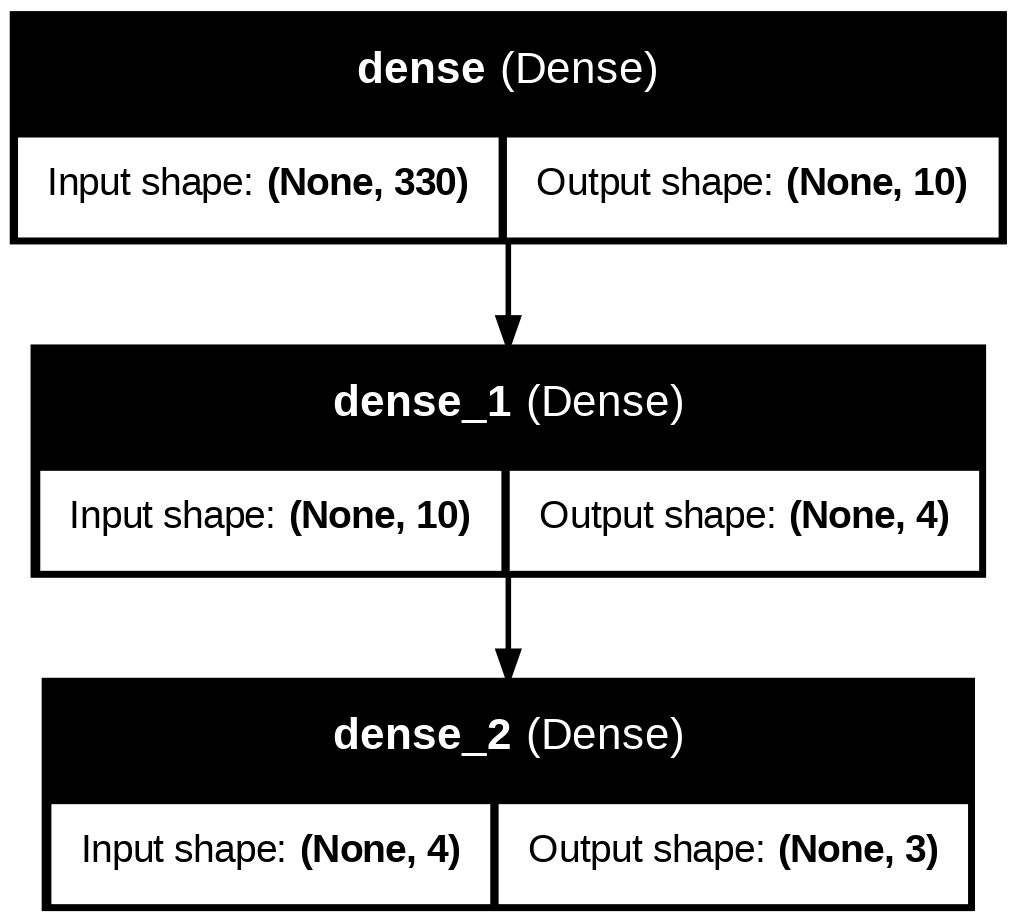

In [23]:
plot_model(model, to_file="model.png",
               show_shapes=True, show_layer_names=True)

In [24]:
history=model.fit(X,y_oh, epochs=15, validation_split=0.2,batch_size=16, verbose=1)

Epoch 1/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.5006 - loss: 1.0063 - val_accuracy: 0.6953 - val_loss: 0.7506
Epoch 2/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7147 - loss: 0.7027 - val_accuracy: 0.7060 - val_loss: 0.7100
Epoch 3/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7318 - loss: 0.6604 - val_accuracy: 0.7120 - val_loss: 0.6954
Epoch 4/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7374 - loss: 0.6531 - val_accuracy: 0.7115 - val_loss: 0.6988
Epoch 5/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7383 - loss: 0.6474 - val_accuracy: 0.7169 - val_loss: 0.6864
Epoch 6/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7368 - loss: 0.6487 - val_accuracy: 0.7148 - val_loss: 0.6921
Epoch 7/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7399 - loss: 0.6464 - val_accuracy: 0.7155 - val_loss: 0.6900
Epoch 8/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7417 - loss: 0

1. Did the model successfully train? Plot different metrics and evolution of train/validation loss.

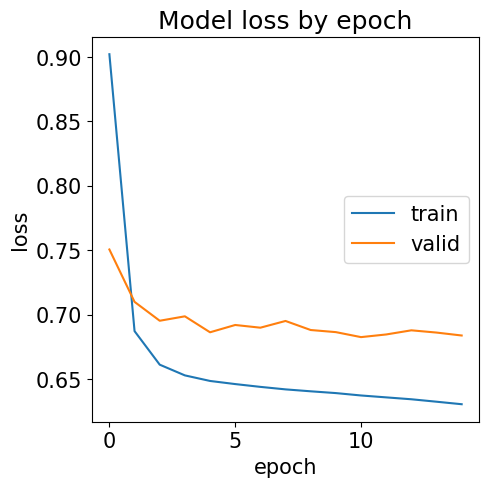

In [25]:
# Loss evolution
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

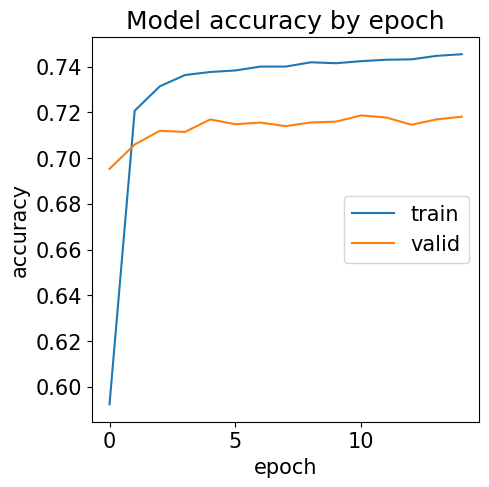

In [26]:
#Plot Accuracy
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

2. How does the model perform for the independent test ? (Plot Accuracy, Loss, Confusion matrix (Frequencies) [TIPS: Use seaborn heatmap]

In [27]:
import seaborn as sns
confusion_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1),
                                                    np.argmax(model.predict(Xcnn_test), axis=1))
sns.heatmap(confusion_matrix/confusion_matrix.sum(axis=1), annot = True) #plots frequency

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 15, 22), dtype=float32). Expected shape (None, 330), but input has incompatible shape (32, 15, 22)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 15, 22), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

<Axes: >

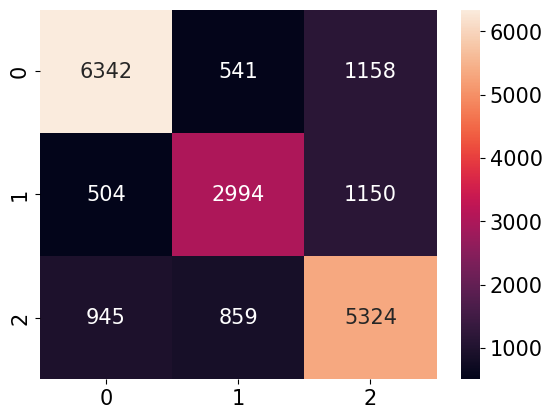

In [ ]:
sns.heatmap(confusion_matrix, annot=True, fmt = 'd') #plots occurences

3. What is the problem with a unique test set ? How can we resolve this problem ? Try to implement a approach to overcome this problem. [TIPS: Use sklearn]

Use K-Fold Cross-Validation. This splits the data into K parts and trains/tests K times so every data point is used for testing once.

4. Try a different architecture: Convolutional network and measure performance

5. What do you think about model performances? Check per-class model performance. Compare to Dense neural network

6. How could you overcome the problem of different class population ?

Oversampling: Duplicating samples of the minority class (Strands).

Undersampling: Removing samples of the majority class (Helices).

Focal Loss: A loss function that "down-weights" easy examples and focuses the model on hard-to-learn classes

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weights.compute_class_weight(
    class_weights = "balanced",
    classes = np.unique(Y3cl),
    y = Y3cl)

class_weights = dict(enumerate(class_weights))

print(f"Class weights {class_weights}\n")

NameError: name 'class_weights' is not defined

7. What is the problem if we let the training continue for too many epochs ?

This leads to Overfitting. The model begins to memorize the specific training sequences (including the noise) rather than learning the general physical rules of protein folding.

8. And if we try to predict the B-factor, what changes do we need to make?

Output layer: Dense(1) with a linear activation (or no activation).

Loss function: MSE (Mean Squared Error) or MAE.

Interpretation: The model now outputs a continuous value representing atom displacement/flexibility rather than a category.

9. How can we implement a complex architecture ? [TIPS: Functionnal API]

The Sequential API is like a stack of pancakes; one layer must follow the next. The Functional API is like a graph/network. It allows for "skip connections" (adding x to f(x)), which is the definition of a ResNet.

10. Implement CNN Resnet

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def residual_block(x_input, channels, kernel_size=3):
    # 1. Create the shortcut (the "identity" or "projection")
    x_shortcut = x_input

    # If the input channels != output channels, we must project the shortcut
    # to the same dimension using a 1x1 convolution.
    if x_input.shape[-1] != channels:
        x_shortcut = Conv1D(channels, kernel_size=1, padding='same')(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)

    # 2. The main path (BatchNorm -> ReLU -> Conv)
    x = BatchNormalization()(x_input)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size, padding='same')(x)

    # 3. Add the shortcut back to the main path
    x = Add()([x, x_shortcut])
    return x

# Building the model
inputs = Input(shape=(15, 22))
x = Conv1D(32, kernel_size=3, padding='same')(inputs) # Initial projection to 32 channels

for i in range(5): # 5 Blocks
    x = residual_block(x, channels=32)

x = GlobalAveragePooling1D()(x) # Flattening the sequence info
x = Dense(32, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(Xcnn_train, y_train,
                    epochs=15,
                    batch_size=16,
                    validation_data=(Xcnn_test, y_test), # we should use the split data that we made before
                    verbose=1)

Epoch 1/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - accuracy: 0.6700 - loss: 0.7312 - val_accuracy: 0.7588 - val_loss: 0.5848
Epoch 2/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 86s 17ms/step - accuracy: 0.7789 - loss: 0.5393 - val_accuracy: 0.7958 - val_loss: 0.5041
Epoch 3/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 96s 19ms/step - accuracy: 0.7953 - loss: 0.4965 - val_accuracy: 0.7973 - val_loss: 0.5075
Epoch 4/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 137s 18ms/step - accuracy: 0.8114 - loss: 0.4660 - val_accuracy: 0.8044 - val_loss: 0.4818
Epoch 5/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 95s 19ms/step - accuracy: 0.8185 - loss: 0.4495 - val_accuracy: 0.8133 - val_loss: 0.4554
Epoch 6/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 89s 18ms/step - accuracy: 0.8250 - loss: 0.4347 - val_accuracy: 0.8061 - val_loss: 0.4817
Epoch 7/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 92s 19ms/step - accuracy: 0.8292 - loss: 0.4207 - val_accuracy: 0.8226 - val_loss: 0.4389
Epoch 8/15
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - accuracy: 0.8350 

620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


<Axes: >

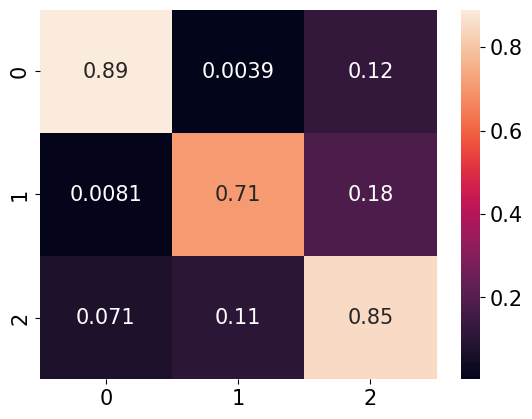

In [ ]:
import seaborn as sns
confusion_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1),
                                                    np.argmax(model.predict(Xcnn_test), axis=1))
sns.heatmap(confusion_matrix/confusion_matrix.sum(axis=1), annot = True) #plots frequency

<Axes: >

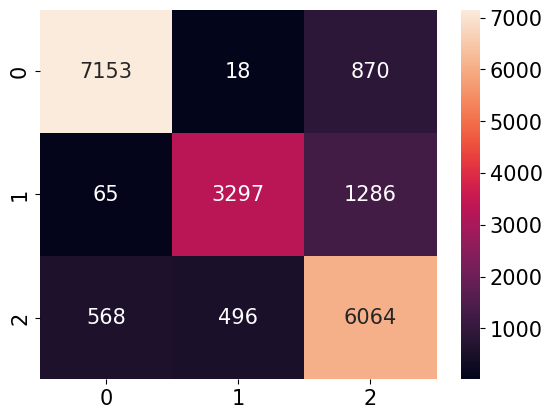

In [ ]:
sns.heatmap(confusion_matrix, annot=True, fmt = 'd') #plots occurences

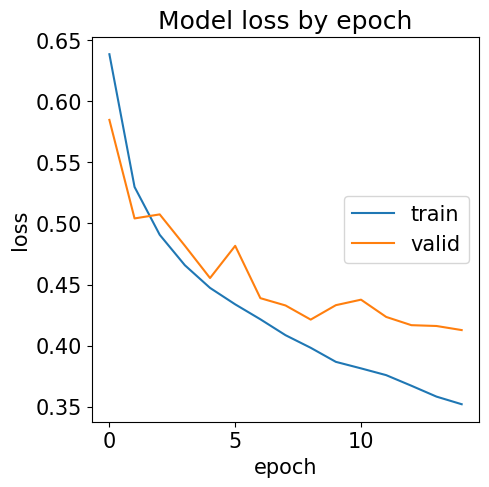

In [ ]:
#Plot loss
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

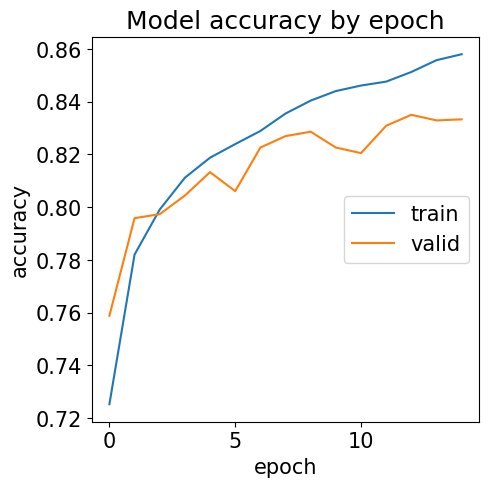

In [ ]:
#Plot Accuracy
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

Conclusion:
* CNNs are superior here because they use a sliding window (kernel) to capture local patterns (like the hydrogen bonding patterns that form an Alpha-Helix).